In [0]:
!pip install --upgrade pandas

In [0]:
!pip install --upgrade sklearn

In [0]:
!pip install bokeh plotly
%load_ext autoreload

In [0]:
!pip install cufflinks --upgrade

In [475]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from os import path
from sklearn.decomposition import SparsePCA, PCA
from sklearn.preprocessing import scale
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.manifold import MDS
from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import Lasso
from bokeh.plotting import figure, output_notebook, show

In [514]:
import personality
reload(personality)
from personality import *

In [275]:
X = prep_X(read_surveys())
one = X.iloc[:, 0:65]
others = X.iloc[:, 65:]

In [277]:
model = SparsePCA(5, .8).fit(scale(X))
projected = model.transform(scale(X))

In [488]:
dist_one = scale(pairwise_distances(one, metric = "l2"))
dist_others = scale(pairwise_distances(others, metric = "l2"))
dist_all = scale(pairwise_distances(X, metric = "l2"))
dist_f_all = scale(pairwise_distances(projected, metric = "l2"))

fived = big_five_projection(X)
dist_five = scale(pairwise_distances(fived, metric = 'l2'))

get_diff = lambda a,b: np.linalg.norm(a - b)/np.linalg.norm(a)

ids = read_surveys().user_id
bigfive = pd.read_csv("educatalyst/Auxil/q1_key_bigfive.csv")
bigfive_types = bigfive.bigfive_lbl_eng.unique()
fiveframe = pd.DataFrame(fived, columns = bigfive_types)

In [279]:
bigfive_types

array(['Energy / Extraversion', 'Agreeableness', 'Conscientiousness',
       'Emotional Instability', 'Intellect / Openness'], dtype=object)

In [5]:
from bokeh.charts import Scatter

def viz_students(m, selected):
    d = pd.DataFrame(m, columns = ['one', 'two']).assign(user_id = ids, selected = selected)
    d.plot.scatter(x = 'one', y = 'two', c = 'selected')

In [0]:
# alpha = .4 - .75 looks to be a range....
from sklearn.model_selection import GridSearchCV
cv = KFold(3, random_state = 1, shuffle = True)
t = fived[:, [0,1,2,4]]
m = GridSearchCV(MultiLasso(), {'alpha': np.arange(0.05, 1.5, .05)}, cv = cv, scoring='neg_mean_squared_error')
pd.DataFrame(m.fit(others, t).cv_results_)

In [533]:
t = fived[:, [0,1,2,4]]
m = GridSearchCV(MultiElasticNet(), {'alpha': np.arange(0.05, 1.5, .05), 'l1_ratio': np.arange(0.2, 1.0, .05)}, cv = cv, scoring='neg_mean_squared_error')
res = pd.DataFrame(m.fit(others, t).cv_results_)

In [544]:
res[res.mean_test_score > -36 ].sort_values('param_l1_ratio', ascending = False).head()

     mean_fit_time  mean_score_time  mean_test_score  mean_train_score  \
247       0.003448         0.000664       -35.968774        -21.136052   
263       0.003461         0.000666       -35.994361        -21.639367   
231       0.004402         0.000742       -35.976331        -20.627964   
198       0.003306         0.000656       -35.977539        -19.379983   
294       0.003750         0.000837       -35.870249        -22.387670   

    param_alpha param_l1_ratio                               params  \
247         0.8           0.55   {u'alpha': 0.8, u'l1_ratio': 0.55}   
263        0.85           0.55  {u'alpha': 0.85, u'l1_ratio': 0.55}   
231        0.75           0.55  {u'alpha': 0.75, u'l1_ratio': 0.55}   
198        0.65            0.5   {u'alpha': 0.65, u'l1_ratio': 0.5}   
294        0.95            0.5   {u'alpha': 0.95, u'l1_ratio': 0.5}   

     rank_test_score  split0_test_score  split0_train_score  \
247               98         -34.040357          -21.272276   
26

In [530]:
m.best_score_
m.best_params_

{'alpha': 0.95000000000000007, 'l1_ratio': 0.10000000000000001}

In [545]:
enet = MultiElasticNet(alpha = 0.8, l1_ratio = .55).fit(others, t)
enet.coef_

[array([  2.39069332e-01,   1.72935226e-01,   1.30320626e+00,
          2.55701708e-01,  -2.25176520e-01,  -5.72292163e-01,
         -4.90099904e-02,   0.00000000e+00,   3.86576397e-01,
         -0.00000000e+00,   1.18926175e+00,   0.00000000e+00,
         -0.00000000e+00,   6.53637806e-01,   8.46849465e-01,
         -0.00000000e+00,   3.06028082e-01,  -0.00000000e+00,
         -0.00000000e+00,   3.93590876e-01,   9.19196576e-01,
          1.07291510e-03,   5.80321979e-02,   4.78886649e-01,
         -3.67832981e-01,  -3.49694467e-01,   0.00000000e+00,
          0.00000000e+00,   9.14832830e-01,   0.00000000e+00,
         -0.00000000e+00,   1.55931127e-01,   3.13625485e-01,
         -0.00000000e+00,   0.00000000e+00,   5.93393307e-01,
          5.51382603e-01,   0.00000000e+00]),
 array([ 0.52725814, -0.        ,  1.24623375, -0.        ,  0.        ,
        -0.        ,  0.        ,  0.14795422,  0.        ,  0.        ,
         0.96816237,  0.80105088, -0.43200445,  0.39135806,  0. 

In [506]:
cross_val_score(MultiElasticNet(alpha = 0.95, l1_ratio = .1), others, t, cv = cv)

array([ 0.51805466,  0.55338928,  0.48875089])

In [507]:
from sklearn.model_selection import LeaveOneOut, cross_val_score, KFold
t = fived[:, [0,1,2,4]]
cross_val_score(MultiLasso(alpha = .8), others, t, cv = cv)

array([ 0.45602609,  0.49758534,  0.48213927])

In [489]:
comps = get_big_five_comps(bigfive)
comps.shape

(65, 5)

In [74]:
# is in turn, find a 1 dimensional line that comes closes to replicating that (regression -- sparsity L1?). 

neighbors = NearestNeighbors(algorithm = 'brute').fit(fived).kneighbors()[1]
selected = np.in1d(range(fived.shape[0]), neighbors[0])

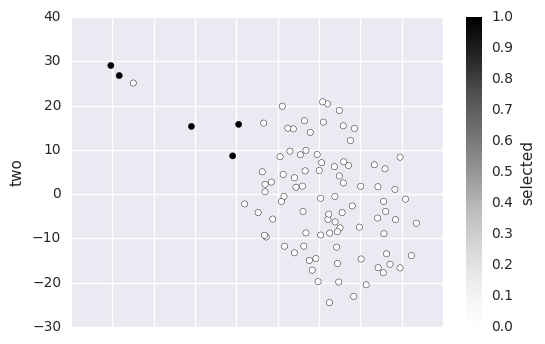

In [76]:
viz_students(MDS().fit_transform(fived), selected)

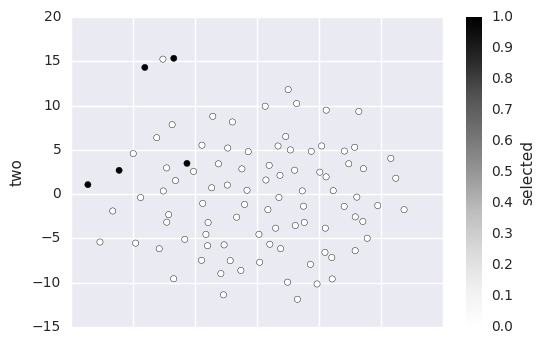

In [77]:
viz_students(MDS().fit_transform(others), selected)

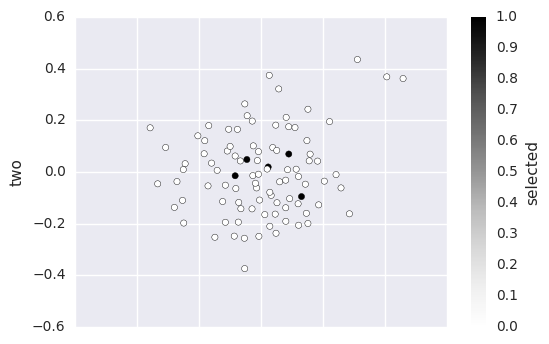

In [20]:
viz_students(MDS().fit_transform(projected), selected)

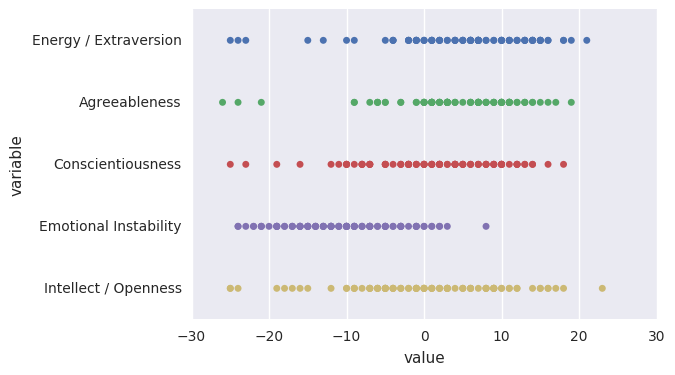

In [31]:
show((x = 'value', y = 'variable', data = fiveframe.melt(), orient = 'h')

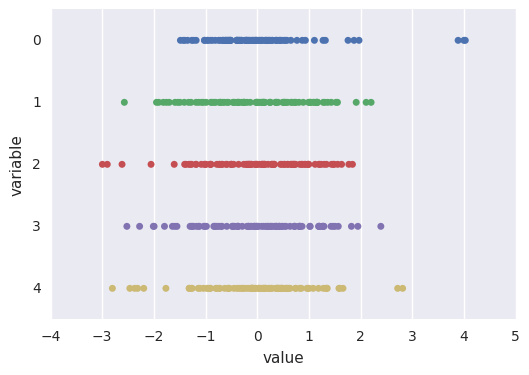

In [113]:
comps = np.matrix(model.components_).T
d = pd.DataFrame(scale(X.dot(comps)))
sns.stripplot(x = 'value', y = 'variable', data = d.melt(), orient = 'h')

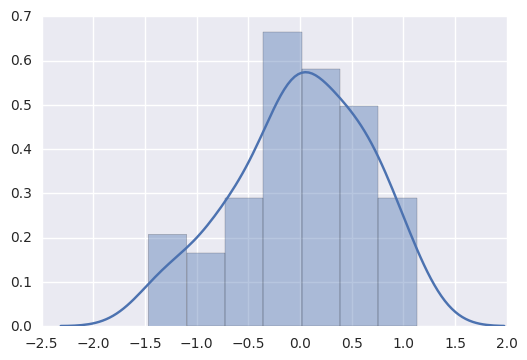

In [11]:
# take a look at the questions on the axes...
(np.sign(np.round(model.components_[0]/5)))

# Look at just the answers to the bigfive problems
one = X.iloc[:, 0:65]

sns.distplot(one.apply(np.mean, 0))
plt.show()